In [63]:
import pandas as pd
import ast
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

# Работа с исходными данными

## Обработка метаданных

Загрузим метаданные о датасете и данные о диагнозах

In [9]:
meta_df = pd.read_csv('ptbxl_database.csv', index_col=0)
scp_df = pd.read_csv('scp_statements.csv')

meta_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",LAD,NaN,NaN,1.0,False,True,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MID,Stadium II-III,NaN,1.0,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,"{'ISCAS': 50.0, 'SR': 0.0}",MID,NaN,NaN,1.0,True,True,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


Отфильтруем данные.

В метаданных нужно оставить столбцы, включающие в себя диагноз, путь к файлу с временным рядом, разделения на 10 групп. Обработаем столбец с заключениями в соответствии с синтаксисом словаря.

В данных о диагнозах оставим только диагностические заключения

In [10]:
meta_df.scp_codes = meta_df.scp_codes.apply(lambda x: ast.literal_eval(x))
meta_df = meta_df[['scp_codes', 'strat_fold', 'filename_lr']]


scp_df = scp_df[scp_df.diagnostic == 1]
diagnose_set = set(scp_df['Unnamed: 0'])

meta_df

,scp_codes,strat_fold,filename_lr
ecg_id,,,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",3,records100/00000/00001_lr
2,"{'NORM': 80.0, 'SBRAD': 0.0}",2,records100/00000/00002_lr
3,"{'NORM': 100.0, 'SR': 0.0}",5,records100/00000/00003_lr
4,"{'NORM': 100.0, 'SR': 0.0}",3,records100/00000/00004_lr
5,"{'NORM': 100.0, 'SR': 0.0}",4,records100/00000/00005_lr
...,...,...,...
21833,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",7,records100/21000/21833_lr
21834,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",4,records100/21000/21834_lr
21835,"{'ISCAS': 50.0, 'SR': 0.0}",2,records100/21000/21835_lr


## Загрузка временных рядов

Для дальнейшего анализа будем использовать записи с частотой 100 измерений в секунду. Загрузим записи в numpy массив

In [50]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = ''
sampling_rate=100

X = load_raw_data(meta_df, sampling_rate, path)
X = X.transpose(0,2,1)
X.shape

(21837, 12, 1000)

Размер полученных данных соответствует 21837 случаям, для каждого проведено 12 одновременных измерений по 10*100=1000 точек

Визуализируем одно из ЭКГ

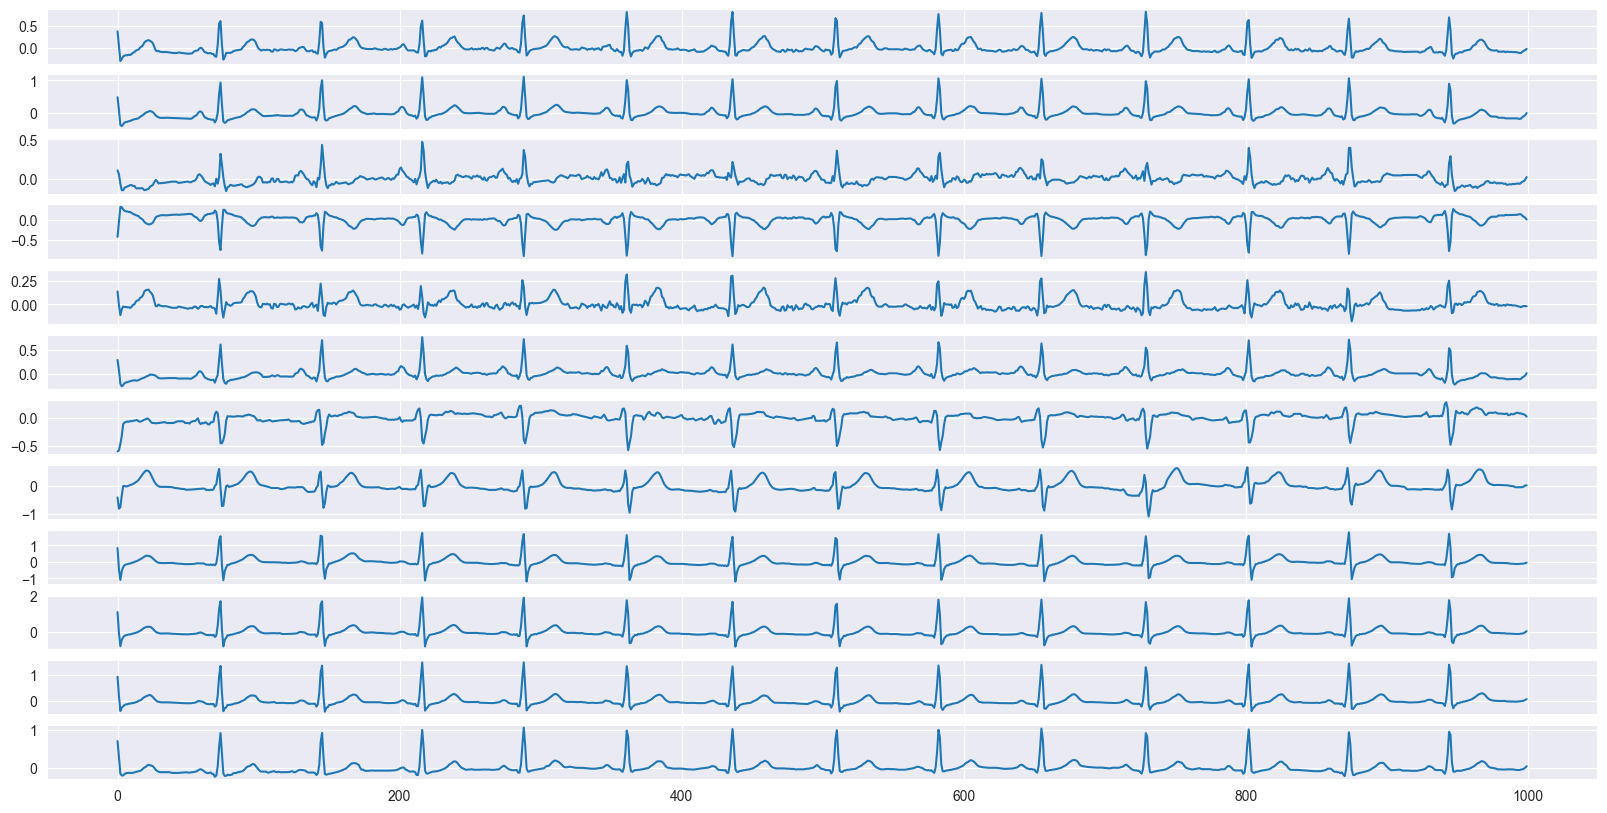

In [66]:
sample = X[45]

fig, axes = plt.subplots(12, 1, figsize=(20,10), sharex=True)
for i in range(12):
    sns.lineplot(x=np.arange(sample.shape[1]), y=sample[i, :], ax=axes[i])
plt.show()

## Разметка данных

Разметим ЭКГ, будем использовать только диагностические заметки, уровень будет равен степени уверенности в диагнозе

In [146]:
def marking(labels, classes):
    # Словарь для индексов классов
    classes_dict = {key: value for key, value in zip(classes, range(len(classes)))}
    res = np.zeros([len(labels), len(classes)])
    # Пройдёмся по каждому диагнозу, в нём просматриваем словарь, проверяем входит ли запись в диагнозы и, если да, то записываем значение в пределах [0,1]
    for i, ecg in enumerate(labels):
        for key, value in ecg.items():
            if key in classes_dict:
                j = classes_dict[key]
                res[i,j] = value/100
    return res    
    

In [147]:
Y = marking(meta_df.scp_codes, diagnose_set)

In [151]:
a = np.sum(Y,axis=1).tolist()

In [154]:
np.count_nonzero(a)

21417

In [156]:
len(a) - np.count_nonzero(a)

420

In [127]:
t = iter(enumerate(a1))

In [142]:
type(b)

dict

In [144]:
for key, value in b.items():
    print(1)

1
1


In [145]:
b.items()

dict_items([('NORM', 100.0), ('SR', 0.0)])